### Setup
###### This is just imports and configuration


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 1.5
darkgrey = '#3A3A3A'
lightgrey = '#414141'
barblue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
plt.rcParams['text.color'] = darkgrey
plt.rcParams['axes.labelcolor'] = darkgrey
plt.rcParams['xtick.color'] = lightgrey
plt.rcParams['ytick.color'] = lightgrey

### Example problem 

Your team is at the beginning of a new cycle/quarter, and the PO is happy with the inception we just ran together. We found clear goals for the next months and defined 3 clear 
**initiatives**. You even went further and did some User Story mapping that allowed you to break down the different initiatives into stories:

- **Initiative #1**: 6 user stories
- **Initiative #2**: 8-10 user stories
- **Initiative #3**: 7 user stories


Now, the PO wants you to *estimate* how long will it take you to have this in production. 

**What would you tell your PO?**

# Using the Montecarlo method to produce a forecasting based on the past data

## 1. Reading and analyzing the data

Using pandas `read_csv` function, read the JIRA data into a DataFrame. Take the `Issue key`, `Resolved` and `Issue Type` columns from the data and ignore the rest.

Display the result.

In [18]:
sample_stories = pd.read_csv('data/delivered_tickets.csv')[['Issue key','Resolved', 'Issue Type']]
# Ignore the time, use only dates
sample_stories['Resolved'] = pd.to_datetime(sample_stories['Resolved'],format='%d/%b/%y %I:%M %p').dt.normalize()

#### Calculating Throughput
The number of items delivered each day is called (daily) *troughput*. Transform story data into a measure of the historical throughput of the team by calculating how many items were delivered on each date.

- You can use the `crosstab` function to "pivot" the table aggregating stories based on the date they were solved
- With the `reindex` function, you can create a complete table (for all the dates), filling each date with the corresponding throughput (or 0 otherwise)

In [19]:
date_range = pd.date_range(start=sample_stories.Resolved.min(),end=sample_stories.Resolved.max())

throughput = pd.crosstab(sample_stories.Resolved, sample_stories['Issue Type'], colnames=[None])

throughput['Throughput'] = throughput.Bug + throughput.Epic + throughput.Story + throughput.Task
throughput = throughput.reindex(date_range).fillna(0).astype(int).rename_axis('Date')

Now that we have calculated our throughput, let's take a look at it. 

- Use the `plot` method to generate some plotting axes (you can add a title, x_label, y_label and other stuff to the axes too!).

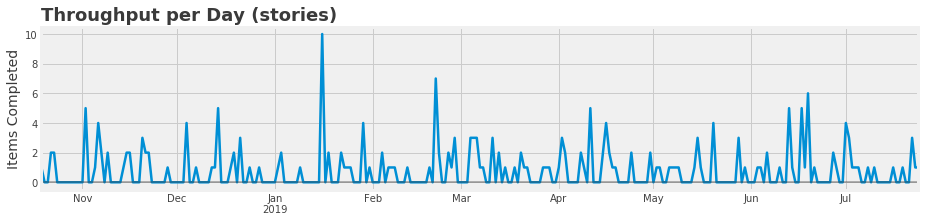

In [20]:
ax = throughput.plot(y='Throughput', linewidth=2.5, figsize=(14, 3), legend=None)
ax.set_title("Throughput per Day (stories)", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_xlabel('')
ax.set_ylabel('Items Completed')
ax.axhline(y=0, color=lightgrey, alpha=.5);

- Using the `resample` method, calculate the weekly throughput of the team and plot it.

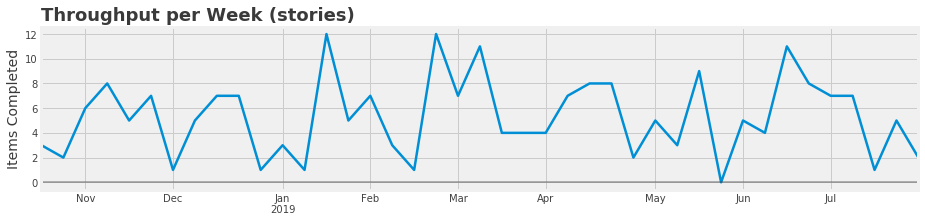

In [21]:
throughput_per_week = pd.DataFrame(
    throughput['Throughput'].resample('W-Mon').sum()).reset_index()
ax = throughput_per_week.plot(
    x='Date', y='Throughput', linewidth=2.5, figsize=(14, 3), legend=None)
ax.set_title("Throughput per Week (stories)", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_xlabel('')
ax.set_ylabel('Items Completed')
ax.axhline(y=0, color=lightgrey, alpha=.5);

## 2. Sampling the past data to produce simulations

The Montecarlo method is based on "Sample-Importance resampling": we take some data from the past and sample it, with a sampling distibution that follows that of the data.

In other words: you take the throughput data of the last `N` days, and pick from it randomly. The probability of getting a particular throughput is given by the number of times this has happened in the past.

To **sample** or past data, we'll first select the last 100 days of data.

- Using the `sample` method, we can take a random sample out of a pandas `Series` object. Each of the columns of a `DataFrame` is a `Series`. 
- We need to generate sequences of days

In [23]:
LAST_DAYS = 100
SIMULATION_ITEMS = 15
START_DATE = pd.to_datetime('2019-07-22')
SIMULATIONS = 1000

In [29]:
def simulate_wwibd(data, stories_to_deliver, idx, total_simulations):
    def print_progress(i, N):
        if (i+1) == N:
            print("\r%d simulations run.\n" % N)
        else:
            print("\rRunning simulation %d of %d" % (i + 1, N), end='')
    
    days = 0
    total = 0
    while total <= stories_to_deliver:
        total += data.sample(n=1).iloc[0].Throughput
        days += 1
    completion_date = START_DATE + pd.Timedelta(days, unit='d')
    print_progress(idx, total_simulations)
    return completion_date

In [30]:
dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)

samples = [simulate_wwibd(dataset, SIMULATION_ITEMS, i, SIMULATIONS) for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=['Date'])
distribution = samples.groupby(['Date']).size().reset_index(name='Frequency')

1000 simulations run.9 of 1000



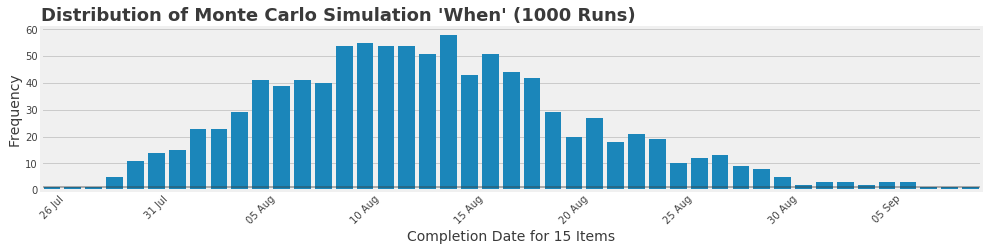

In [33]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(x='Date', y='Frequency', data=distribution, color=barblue)
ax.set_title(f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Completion Date for {SIMULATION_ITEMS} Items")
ax.set_ylabel('Frequency')
unique_dates = sorted(list(distribution['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 5)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime('%d %b')
                    for i in date_ticks], rotation=45)
ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

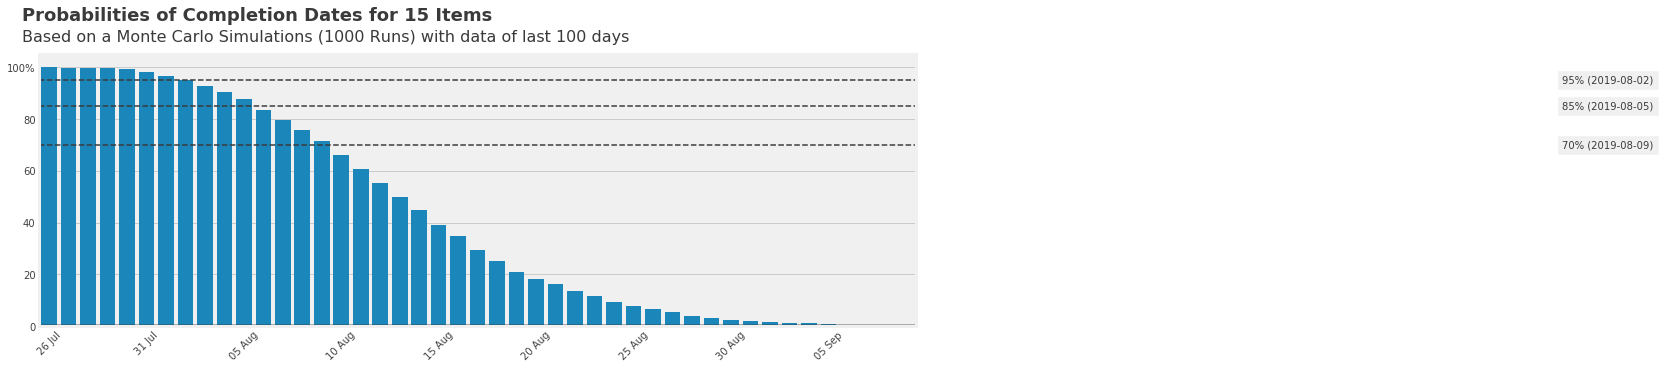

In [34]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100 * \
    distribution.Frequency.cumsum()/distribution.Frequency.sum()
plt.figure(figsize=(14, 5))
ax = sns.barplot(x='Date', y='Probability', data=distribution, color=barblue)
ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completion Dates for {SIMULATION_ITEMS} Items", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {LAST_DAYS} days", fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=70, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')
label_xpos = distribution['Date'].max() - pd.Timedelta(30, unit='d')
ax.text(y=70, x=80, s=f"70% ({samples.Date.quantile(0.3).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=80, s=f"85% ({samples.Date.quantile(0.15).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=80, s=f"95% ({samples.Date.quantile(0.05).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%'])

unique_dates = sorted(list(distribution['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 5)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime('%d %b')
                    for i in date_ticks], rotation=45);

# Simulation: When will it be done?

In [37]:
### SETTINGS ####
LAST_DAYS = 100
SIMULATION_DAYS = 14
SIMULATIONS = 10000
###

dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)
samples = [dataset.sample(n=SIMULATION_DAYS, replace=True).sum(
).Throughput for i in range(SIMULATIONS)]

In [38]:
samples = pd.DataFrame(samples, columns=['Items'])

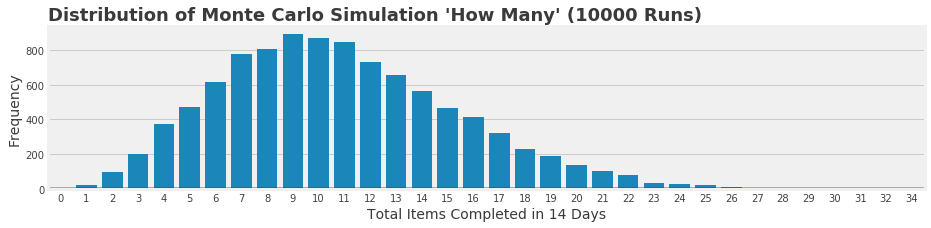

In [39]:
distribution = samples.groupby(['Items']).size().reset_index(name='Frequency')
plt.figure(figsize=(14, 3))
ax = sns.barplot(x='Items', y='Frequency', data=distribution, color=barblue)
ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel('Frequency')
ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

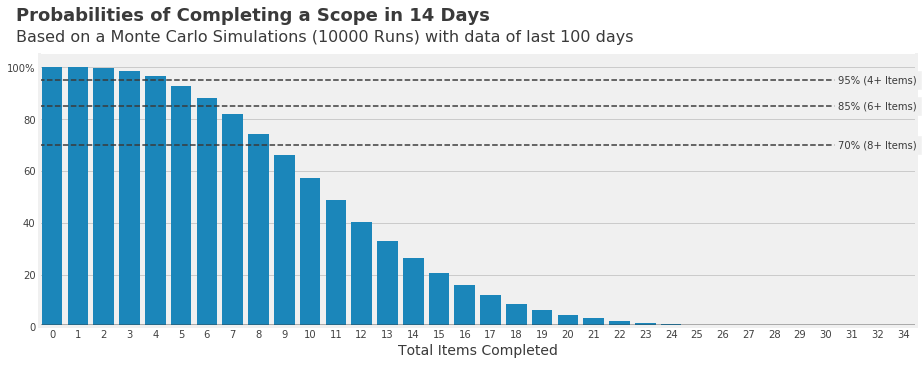

In [40]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100 * \
    distribution.Frequency.cumsum()/distribution.Frequency.sum()
plt.figure(figsize=(14, 5))
ax = sns.barplot(x='Items', y='Probability', data=distribution, color=barblue)
ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completing a Scope in {SIMULATION_DAYS} Days", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {LAST_DAYS} days", fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('Total Items Completed')
ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=70, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')
label_xpos = distribution['Items'].max()-2
ax.text(y=70, x=label_xpos, s=f'70%% (%d+ Items)' % samples.Items.quantile(0.3),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%']);